In [102]:
import re
import unicodedata
import pandas as pd
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from env import get_db_url
import acquire as acq

In [2]:
#get some spam
df = pd.read_sql('SELECT * FROM spam',get_db_url('spam_db'))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5572 non-null   int64 
 1   label   5572 non-null   object
 2   text    5572 non-null   object
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


In [4]:
df.head()

,id,label,text
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [16]:
df.text.apply(len).nlargest()

1084    910
1862    790
2433    632
1578    611
2157    588
Name: text, dtype: int64

In [8]:
nltk.corpus.stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [17]:
#after looking at stopwords, put in some text shorthand
#not sure how to use this yet, as it may be indicative of spam
text_shorthand = ['r','u','2','ur','b']

##### Create subsets and Do some cleaning


In [26]:
def spam_cleaned_list(words):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    #basic clean - unicode & lower
    words = unicodedata.normalize('NFKD',words).encode('ascii','ignore').decode('utf-8','ignore').lower()
    #get rid of extra characters and break into list
    word_list = re.sub(r'[^\w\s]','',words).split()
    #remove stopwords
    word_list = [word for word in word_list if word not in stopwords]
    #lemmatize and return list
    return [wnl.lemmatize(word) for word in word_list]

In [27]:
#join every text cell that has a corresponding label of 'ham', then apply cleaning function
ham_words = spam_cleaned_list(' '.join(df[df.label=='ham'].text))
spam_words = spam_cleaned_list(' '.join(df[df.label=='spam'].text))
all_words = spam_cleaned_list(' '.join(df.text))

In [29]:
ham_words[0:5]

['go', 'jurong', 'point', 'crazy', 'available']

In [30]:
spam_words[0:10]

['free', 'entry', '2', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts']

##### Get some basic stats

In [51]:
#get frequency of words
ham_count = pd.Series(ham_words).value_counts()
spam_count = pd.Series(spam_words).value_counts()
all_count = pd.Series(all_words).value_counts()

In [52]:
#put in dataframe
word_counts = (pd.concat([all_count, ham_count, spam_count], axis=1,keys=['all_count','ham_count','spam_count'])
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [58]:
#now get actual frequencies
word_counts['ham_freq'] = word_counts['ham_count'] / word_counts.ham_count.sum()
word_counts['spam_freq'] = word_counts['spam_count'] / word_counts.spam_count.sum()

#get words with greatest difference in frequency
word_counts['freq_diff'] = word_counts.spam_freq - word_counts.ham_freq

In [59]:
word_counts.head()

,all_count,ham_count,spam_count,ham_freq,spam_freq,freq_diff
u,1182,1027,155,0.025787,0.012395,-0.013392
call,600,241,359,0.006051,0.028709,0.022657
2,478,305,173,0.007658,0.013834,0.006176
im,462,449,13,0.011274,0.001040,-0.010234
get,397,314,83,0.007884,0.006637,-0.001247


In [62]:
word_counts.sort_values(by='freq_diff',ascending=False,inplace=True)

In [68]:
subset = word_counts[0:10]

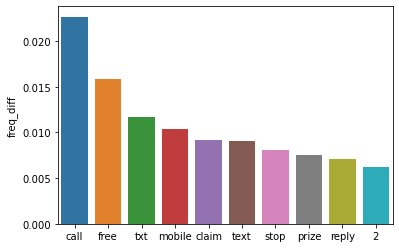

In [71]:
sns.barplot(data =subset, x=subset.index,y='freq_diff');
#NOTE: for some reason catplot generated an error

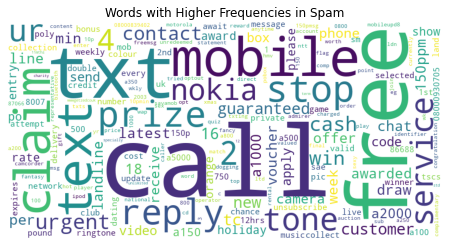

In [113]:
#spam word cloud
data = word_counts[word_counts.freq_diff > 0].freq_diff.to_dict()
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.title('Words with Higher Frequencies in Spam')
plt.show()

##### 1b) Create and explore bigrams for the spam data
- Visualize in word cloud
- how do they compare to a ham bigrams?

In [78]:
top_20_spam_bi = pd.Series(nltk.ngrams(spam_words,2)).value_counts().head(20)
top_20_ham_bi = pd.Series(nltk.ngrams(ham_words,2)).value_counts().head(20)

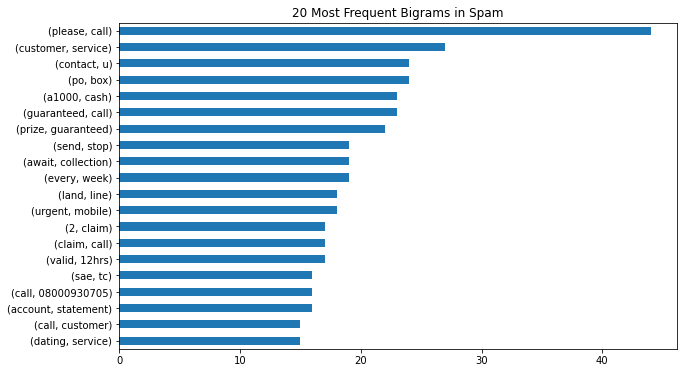

In [77]:
top_20_spam_bi.sort_values().plot.barh(figsize=(10,6),title='20 Most Frequent Bigrams in Spam');

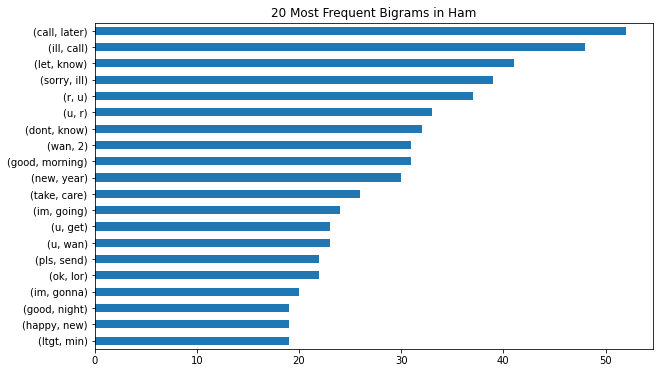

In [79]:
top_20_ham_bi.sort_values().plot.barh(figsize=(10,6),title='20 Most Frequent Bigrams in Ham');

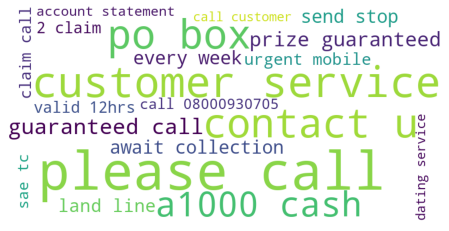

In [82]:
#spam word cloud
data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bi.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

##### 1c) Is there any overlap in the bigrams fro the spam and ham data?

In [96]:
#Nope - not in the top 20

##### 1d) Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data

In [98]:
top_20_spam_tri = pd.Series(nltk.ngrams(spam_words,3)).value_counts().head(20)
top_20_ham_tri = pd.Series(nltk.ngrams(ham_words,3)).value_counts().head(20)

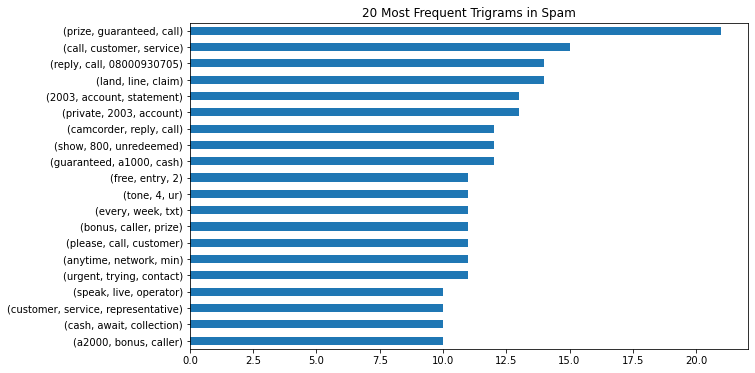

In [99]:
top_20_spam_tri.sort_values().plot.barh(figsize=(10,6),title='20 Most Frequent Trigrams in Spam');

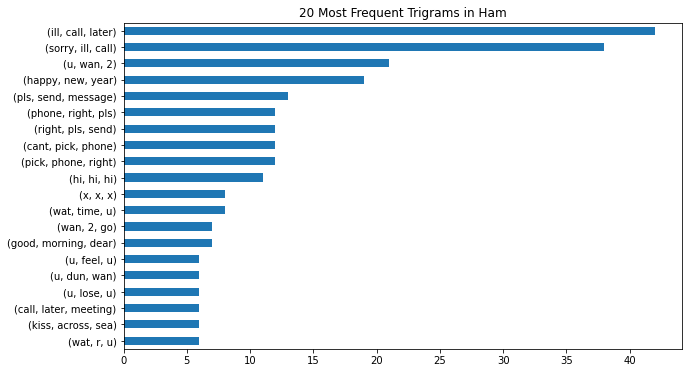

In [100]:
top_20_ham_tri.sort_values().plot.barh(figsize=(10,6),title='20 Most Frequent Trigrams in Ham');

##### 2) Explore the blog articles

In [104]:
headers = {'User-Agent': 'Codeup Data Science - Jemison'}
urls = ['https://codeup.com/data-science/jobs-after-a-coding-bootcamp-part-1-data-science/',
        'https://codeup.com/data-science/math-in-data-science/',
        'https://codeup.com/data-science/transition-into-data-science/',
        'https://codeup.com/data-science/data-science-career/',
        'https://codeup.com/data-science/data-science-without-a-degree/']
topics = ["business","sports","technology","entertainment"]

In [105]:
codeup_df = acq.get_blog_articles(urls,headers)
codeup_df.head(3)

,url,title,content
0,https://codeup.com/data-science/jobs-after-a-c...,What Jobs Can You Get After a Coding Bootcamp?,\nIf you are interested in embarking on a care...
1,https://codeup.com/data-science/math-in-data-s...,What are the Math and Stats Principles You Nee...,"\nComing into our Data Science program, you wi..."
2,https://codeup.com/data-science/transition-int...,What is the Transition into Data Science Like?...,\nAlumni Katy Salts and Brandi Reger joined us...


In [106]:
blog_clean = spam_cleaned_list(' '.join(codeup_df.content))

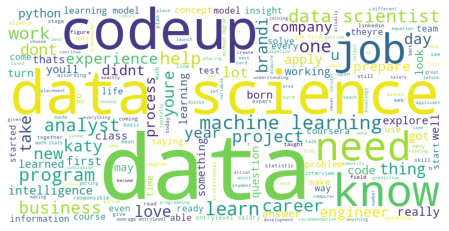

In [109]:
#spam word cloud
img = WordCloud(background_color='white', width=800, height=400).generate(' '.join(blog_clean))
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

##### 3) Explore the news articles
- use the category variable when exploring

In [114]:
news_df = acq.get_news_articles(topics,headers)
news_df.head()

,title,content,category
0,Rupee hits record low of 79.97 against US dollar,The rupee hit a record low of 79.97 against th...,business
1,Rupee closes at an all-time low of 79.98 again...,The rupee on Monday hit a fresh record low as ...,business
2,A fighter to the core: Mahindra praises PV Sin...,Businessman Anand Mahindra took to Twitter to ...,business
3,"BCCI had ₹40 cr in bank when I joined & ₹47,68...","In an Instagram post, Lalit Modi asserted that...",business
4,11 SEBI officials' email accounts hacked & use...,Mumbai police has filed an FIR after the Secur...,business


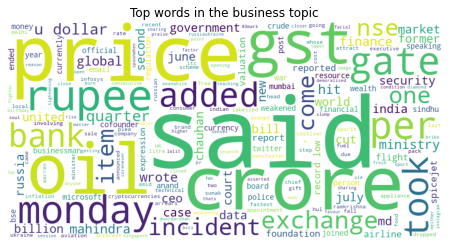

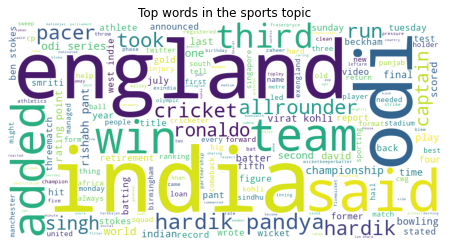

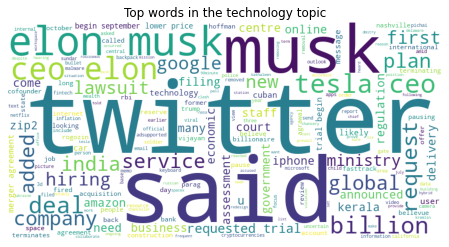

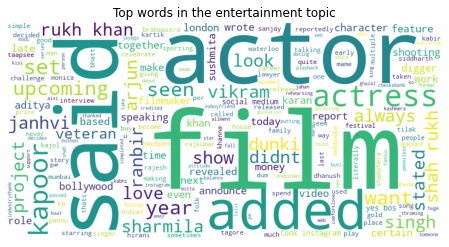

In [122]:
cat_agg = {}
for cat in news_df.category.unique():
    #for each cat, create an aggreggated string of all the contents
    cat_agg[cat] = spam_cleaned_list(' '.join(news_df[news_df.category == cat].content))
    #now let's throw up a wordcloud
    img = WordCloud(background_color='white', width=800, height=400).generate(' '.join(cat_agg[cat]))
    plt.figure(figsize=(8, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Top words in the {cat} topic')
    plt.show()